# Neighborhood Venues Data Mining

- Combines and deduplicates geospatial neighborhood data 
- Requests Foursquare nearby venues and venue categories to build profile of each neighborhood


- Required inputs
 - *_neighborhood_coords.csv per city
- Outputs 
 - 'world_neighborhood_coords.csv'
 - 'foursquare_venues.csv'
 - 'world_neighborhood_venues.csv'
 - 'world_neighborhood_venue_frequency.csv'

## Table of Contents

1. [Compile Global Neighborhood Coordinates](#clean)
    
2. [Fetch Foursquare Categories](#foursquare-categories)
    
3. [Fetch Foursquare Venues](#foursquare)

4. [Prepare model input features](#model-input)

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from foursquare import fetch_venues, fetch_venue_categories, venue_frequency, rank_venues_by_frequency
from geocoder import enrich_neighborhoods_with_geocoder, map_neighborhoods, map_clusters

## Compile global neighborhood coordinates
<a id="clean"/>

In [2]:
beijing = pd.read_csv('data/beijing_neighborhood_coords.csv', index_col=0)
beijing.insert(1, 'City', 'Beijing')
beijing.head()

,Neighborhood,City,Latitude,Longitude
0,Yuqiao,Beijing,39.898820,116.670814
1,Shigezhuang,Beijing,39.931943,116.557680
2,Beitaipingzhuang,Beijing,39.973640,116.363844
3,Yongdingmenwai,Beijing,39.866794,116.392355
4,Jinding Avenue,Beijing,39.934977,116.389006


In [12]:
frankfurt = pd.read_csv('data/frankfurt_neighborhood_coords.csv', index_col=0)
frankfurt.insert(1, 'City', 'Frankfurt')

hongkong = pd.read_csv('data/hong_kong_neighborhood_coords.csv', index_col=0)
hongkong.insert(1, 'City', 'Hong Kong')

london = pd.read_csv('data/london_neighborhood_coords.csv', index_col=0)
london.insert(1, 'City', 'London')

nyc = pd.read_csv('data/new_york_city_neighborhood_coords.csv', index_col=0)
nyc.insert(1, 'City', 'New York City')

shanghai = pd.read_csv('data/shanghai_neighborhood_coords.csv', index_col=0)
shanghai.insert(1, 'City', 'Shanghai')

singapore = pd.read_csv('data/singapore_neighborhood_coords.csv', index_col=0)
singapore.insert(1, 'City', 'Singapore')

tokyo = pd.read_csv('data/tokyo_neighborhood_coords.csv', index_col=0)
tokyo.insert(1, 'City', 'Tokyo')

toronto = pd.read_csv('data/toronto_neighborhood_coords.csv', index_col=0)
toronto.insert(1, 'City', 'Toronto')

zurich = pd.read_csv('data/zurich_neighborhood_coords.csv', index_col=0)
zurich.insert(1, 'City', 'Zurich')

world_coordinates = pd.concat([beijing, frankfurt, hongkong, london, nyc, shanghai, singapore, tokyo, toronto, zurich]).reset_index(drop=True)
world_coordinates

,Neighborhood,City,Latitude,Longitude
0,Yuqiao,Beijing,39.898820,116.670814
1,Shigezhuang,Beijing,39.931943,116.557680
2,Beitaipingzhuang,Beijing,39.973640,116.363844
3,Yongdingmenwai,Beijing,39.866794,116.392355
4,Jinding Avenue,Beijing,39.934977,116.389006
...,...,...,...,...
1389,Langstrasse,Zurich,47.377273,8.526415
1390,Enge,Zurich,47.361789,8.528708
1391,Lindenhof,Zurich,47.372916,8.540176
1392,Leimbach,Zurich,47.390254,8.581406


### Handle duplicates

In [13]:
d = world_coordinates.duplicated
d

<bound method DataFrame.duplicated of           Neighborhood     City   Latitude   Longitude
0               Yuqiao  Beijing  39.898820  116.670814
1          Shigezhuang  Beijing  39.931943  116.557680
2     Beitaipingzhuang  Beijing  39.973640  116.363844
3       Yongdingmenwai  Beijing  39.866794  116.392355
4       Jinding Avenue  Beijing  39.934977  116.389006
...                ...      ...        ...         ...
1389       Langstrasse   Zurich  47.377273    8.526415
1390              Enge   Zurich  47.361789    8.528708
1391         Lindenhof   Zurich  47.372916    8.540176
1392          Leimbach   Zurich  47.390254    8.581406
1393         Wipkingen   Zurich  47.393495    8.528602

[1394 rows x 4 columns]>

In [15]:
world_coordinates.drop_duplicates(inplace=True)
world_coordinates.shape

(1393, 4)

In [27]:
world_coordinates.drop_duplicates(subset=['Latitude', 'Longitude'], inplace=True)
world_coordinates.reset_index(inplace=True, drop=True)
world_coordinates

,Neighborhood,City,Latitude,Longitude
0,Yuqiao,Beijing,39.898820,116.670814
1,Shigezhuang,Beijing,39.931943,116.557680
2,Beitaipingzhuang,Beijing,39.973640,116.363844
3,Yongdingmenwai,Beijing,39.866794,116.392355
4,Jinding Avenue,Beijing,39.934977,116.389006
...,...,...,...,...
1389,Langstrasse,Zurich,47.377273,8.526415
1390,Enge,Zurich,47.361789,8.528708
1391,Lindenhof,Zurich,47.372916,8.540176
1392,Leimbach,Zurich,47.390254,8.581406


10% of locations are duplicates! :(

In [30]:
world_coordinates['City'].value_counts()

New York City    306
Hong Kong        229
Toronto          166
Singapore        145
Shanghai         129
Beijing          111
Tokyo             72
Frankfurt         46
London            32
Zurich            31
Name: City, dtype: int64

In [5]:
# world_coordinates.to_csv('data/world_neighborhood_coords.csv')

world_coordinates = pd.read_csv('data/world_neighborhood_coords.csv', index_col=0)
world_coordinates

,Neighborhood,City,Latitude,Longitude
0,Yuqiao,Beijing,39.898820,116.670814
1,Shigezhuang,Beijing,39.931943,116.557680
2,Beitaipingzhuang,Beijing,39.973639,116.363844
3,Yongdingmenwai,Beijing,39.866794,116.392355
4,Jinding Avenue,Beijing,39.934977,116.389006
...,...,...,...,...
1262,Langstrasse,Zurich,47.377273,8.526415
1263,Enge,Zurich,47.361789,8.528708
1264,Lindenhof,Zurich,47.372916,8.540176
1265,Leimbach,Zurich,47.390254,8.581406


## Fetch venue categories from Foursquare
<a id='foursquare-categories' />

In [2]:
categories = fetch_venue_categories()
categories

[{'name': 'Amphitheater', 'category': 'Arts & Entertainment'},
 {'name': 'Aquarium', 'category': 'Arts & Entertainment'},
 {'name': 'Arcade', 'category': 'Arts & Entertainment'},
 {'name': 'Art Gallery', 'category': 'Arts & Entertainment'},
 {'name': 'Bowling Alley', 'category': 'Arts & Entertainment'},
 {'name': 'Casino', 'category': 'Arts & Entertainment'},
 {'name': 'Circus', 'category': 'Arts & Entertainment'},
 {'name': 'Comedy Club', 'category': 'Arts & Entertainment'},
 {'name': 'Concert Hall', 'category': 'Arts & Entertainment'},
 {'name': 'Country Dance Club', 'category': 'Arts & Entertainment'},
 {'name': 'Disc Golf', 'category': 'Arts & Entertainment'},
 {'name': 'Exhibit', 'category': 'Arts & Entertainment'},
 {'name': 'General Entertainment', 'category': 'Arts & Entertainment'},
 {'name': 'Go Kart Track', 'category': 'Arts & Entertainment'},
 {'name': 'Historic Site', 'category': 'Arts & Entertainment'},
 {'name': 'Karaoke Box', 'category': 'Arts & Entertainment'},
 {'name

In [2]:
c = pd.DataFrame(categories)
c

,name,category
0,Amphitheater,Arts & Entertainment
1,Aquarium,Arts & Entertainment
2,Arcade,Arts & Entertainment
3,Art Gallery,Arts & Entertainment
4,Bowling Alley,Arts & Entertainment
...,...,...
922,Train Station,Travel & Transport
923,Tram Station,Travel & Transport
924,Transportation Service,Travel & Transport
925,Travel Lounge,Travel & Transport


In [13]:
# c.to_csv('data/foursquare_venues.csv')
c = pd.read_csv('data/foursquare_venues.csv', index_col=0)

c.set_index('name', drop=True, inplace=True)
c

,category
name,
Amphitheater,Arts & Entertainment
Aquarium,Arts & Entertainment
Arcade,Arts & Entertainment
Art Gallery,Arts & Entertainment
Bowling Alley,Arts & Entertainment
...,...
Train Station,Travel & Transport
Tram Station,Travel & Transport
Transportation Service,Travel & Transport


In [4]:
categories = list(c.category.value_counts().index)
categories

['Food',
 'Shop & Service',
 'Outdoors & Recreation',
 'Professional & Other Places',
 'Arts & Entertainment',
 'Travel & Transport',
 'College & University',
 'Nightlife Spot',
 'Event',
 'Residence']

## Fetch neighborhood venues from Foursquare
<a id='foursquare' />

In [5]:
world_venues = fetch_venues(neighborhoods=world_coordinates['Neighborhood'],
                            cities=world_coordinates['City'],
                            latitudes=world_coordinates['Latitude'],
                            longitudes=world_coordinates['Longitude']
                            )
world_venues

,Neighborhood,City,Latitude,Longitude,Venue,Venue Category
0,Beitaipingzhuang,Beijing,39.973639,116.363844,Huayang Nianhua Guizhou Hometown Restaurant (贵...,Guizhou Restaurant
1,Beitaipingzhuang,Beijing,39.973639,116.363844,Pizza Hut (必胜客),Pizza Place
2,Beitaipingzhuang,Beijing,39.973639,116.363844,McDonald's (麦当劳),Fast Food Restaurant
3,Beitaipingzhuang,Beijing,39.973639,116.363844,嘉和一品 Jiahe Yipin Congee,Chinese Restaurant
4,Beitaipingzhuang,Beijing,39.973639,116.363844,Mudanyuan Metro Station (地铁牡丹园站),Metro Station
...,...,...,...,...,...,...
15663,Wipkingen,Zurich,47.393495,8.528602,Bahnhof Zürich Wipkingen,Train Station
15664,Wipkingen,Zurich,47.393495,8.528602,Tre Frattelli,Italian Restaurant
15665,Wipkingen,Zurich,47.393495,8.528602,Migros,Grocery Store
15666,Wipkingen,Zurich,47.393495,8.528602,Damas,Eastern European Restaurant


In [6]:
world_venues['Venue Category'].value_counts()

Coffee Shop            762
Café                   604
Chinese Restaurant     594
Japanese Restaurant    411
Italian Restaurant     373
                      ... 
Friterie                 1
Auto Garage              1
College Stadium          1
Gun Range                1
Lottery Retailer         1
Name: Venue Category, Length: 521, dtype: int64

In [6]:
world_venues.to_csv('data/world_neighborhood_venues.csv')

# world_venues = pd.read_csv('data/world_neighborhood_venues.csv', index_col=0)
# world_venues

### Label Venues data with categories

In [15]:
s = c['category']

In [16]:
world_venues['Category'] = world_venues['Venue Category'].apply(lambda x: s.get(x) if s.get(x) else None)
world_venues

,Neighborhood,City,Latitude,Longitude,Venue,Venue Category,Category
0,Beitaipingzhuang,Beijing,39.973640,116.363844,Huayang Nianhua Guizhou Hometown Restaurant (贵...,Guizhou Restaurant,Food
1,Beitaipingzhuang,Beijing,39.973640,116.363844,Pizza Hut (必胜客),Pizza Place,Food
2,Beitaipingzhuang,Beijing,39.973640,116.363844,McDonald's (麦当劳),Fast Food Restaurant,Food
3,Beitaipingzhuang,Beijing,39.973640,116.363844,嘉和一品 Jiahe Yipin Congee,Chinese Restaurant,Food
4,Beitaipingzhuang,Beijing,39.973640,116.363844,Mudanyuan Metro Station (地铁牡丹园站),Metro Station,Travel & Transport
...,...,...,...,...,...,...,...
15663,Wipkingen,Zurich,47.393495,8.528602,Bahnhof Zürich Wipkingen,Train Station,Travel & Transport
15664,Wipkingen,Zurich,47.393495,8.528602,Tre Frattelli,Italian Restaurant,Food
15665,Wipkingen,Zurich,47.393495,8.528602,Migros,Grocery Store,Shop & Service
15666,Wipkingen,Zurich,47.393495,8.528602,Damas,Eastern European Restaurant,Food


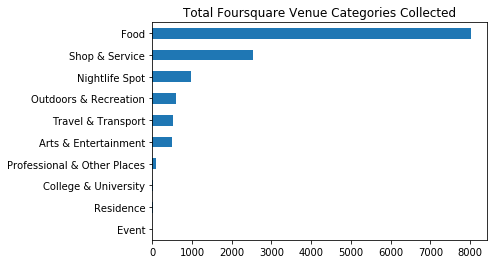

In [7]:
ax = world_venues['Category'].value_counts().plot(kind='barh')
ax.invert_yaxis()
plt.title('Total Foursquare Venue Categories Collected')
plt.show()

Since the bottom four categories each account for less than 1% of data points, and model features space is limited, we should drop them.

### Filter out neighborhoods with venues category accounts for < 1% of venues

In [11]:
len(world_venues)/100

132.95

In [13]:
above_venue_category_threshold = world_venues.groupby('Category').count() >= len(world_venues)/100
above_venue_category_threshold

,Neighborhood,City,Latitude,Longitude,Venue,Venue Category,Address
Category,,,,,,,
Arts & Entertainment,True,True,True,True,True,True,True
College & University,False,False,False,False,False,False,False
Event,False,False,False,False,False,False,False
Food,True,True,True,True,True,True,True
Nightlife Spot,True,True,True,True,True,True,True
Outdoors & Recreation,True,True,True,True,True,True,True
Professional & Other Places,False,False,False,False,False,False,False
Residence,False,False,False,False,False,False,False
Shop & Service,True,True,True,True,True,True,True


In [14]:
filtered_venues = world_venues[world_venues['Category'].isin(above_venue_category_threshold[above_venue_category_threshold['Venue'] == True].index)]
filtered_venues.reset_index(drop=True, inplace=True)
filtered_venues

,Neighborhood,City,Latitude,Longitude,Venue,Venue Category,Category,Address
0,Sanlitun,Beijing,39.936105,116.448813,The Opposite House (瑜舍),Hotel,Travel & Transport,"('Sanlitun', 'Beijing')"
1,Sanlitun,Beijing,39.936105,116.448813,Page One (叶壹堂),Bookstore,Shop & Service,"('Sanlitun', 'Beijing')"
2,Sanlitun,Beijing,39.936105,116.448813,Nali Patio (那里花园),Shopping Mall,Shop & Service,"('Sanlitun', 'Beijing')"
3,Sanlitun,Beijing,39.936105,116.448813,The Black Moth,Cocktail Bar,Nightlife Spot,"('Sanlitun', 'Beijing')"
4,Sanlitun,Beijing,39.936105,116.448813,Bottega,Italian Restaurant,Food,"('Sanlitun', 'Beijing')"
...,...,...,...,...,...,...,...,...
13166,Wipkingen,Zurich,47.393495,8.528602,Bahnhof Zürich Wipkingen,Train Station,Travel & Transport,"('Wipkingen', 'Zurich')"
13167,Wipkingen,Zurich,47.393495,8.528602,Tre Frattelli,Italian Restaurant,Food,"('Wipkingen', 'Zurich')"
13168,Wipkingen,Zurich,47.393495,8.528602,Migros,Grocery Store,Shop & Service,"('Wipkingen', 'Zurich')"
13169,Wipkingen,Zurich,47.393495,8.528602,Damas,Eastern European Restaurant,Food,"('Wipkingen', 'Zurich')"


### Filter out neighborhoods with Foursquare venues count < 10

In [22]:
above_venue_count_threshold = world_venues[['Neighborhood', 'City', 'Venue']].groupby(['Neighborhood', 'City']).count() >= 10
above_venue_count_threshold

Venue
Neighborhood City            
A Kung Ngam  Hong Kong  False
Aberdeen     Hong Kong   True
Adelaide     Toronto     True
Admiralty    Hong Kong   True
             Singapore  False
...                       ...
Zōshigaya    Tokyo       True
one-north    Singapore   True
Āntíng Zhèn  Shanghai    True
Ōmori, Ōta   Tokyo       True
Ōyamachō     Tokyo      False

[1078 rows x 1 columns]

In [34]:
world_venues['Address'] = list(zip(world_venues['Neighborhood'], world_venues['City']))
filtered_venues = world_venues[world_venues['Address'].isin(above_threshold[above_threshold['Venue'] == True].index)]
filtered_venues.reset_index(drop=True, inplace=True)

In [37]:
filtered_venues

,Neighborhood,City,Latitude,Longitude,Venue,Venue Category,Category,Address
0,Sanlitun,Beijing,39.936105,116.448813,The Opposite House (瑜舍),Hotel,Travel & Transport,"(Sanlitun, Beijing)"
1,Sanlitun,Beijing,39.936105,116.448813,Page One (叶壹堂),Bookstore,Shop & Service,"(Sanlitun, Beijing)"
2,Sanlitun,Beijing,39.936105,116.448813,Nali Patio (那里花园),Shopping Mall,Shop & Service,"(Sanlitun, Beijing)"
3,Sanlitun,Beijing,39.936105,116.448813,The Black Moth,Cocktail Bar,Nightlife Spot,"(Sanlitun, Beijing)"
4,Sanlitun,Beijing,39.936105,116.448813,Bottega,Italian Restaurant,Food,"(Sanlitun, Beijing)"
...,...,...,...,...,...,...,...,...
13290,Wipkingen,Zurich,47.393495,8.528602,Bahnhof Zürich Wipkingen,Train Station,Travel & Transport,"(Wipkingen, Zurich)"
13291,Wipkingen,Zurich,47.393495,8.528602,Tre Frattelli,Italian Restaurant,Food,"(Wipkingen, Zurich)"
13292,Wipkingen,Zurich,47.393495,8.528602,Migros,Grocery Store,Shop & Service,"(Wipkingen, Zurich)"
13293,Wipkingen,Zurich,47.393495,8.528602,Damas,Eastern European Restaurant,Food,"(Wipkingen, Zurich)"


In [15]:
filtered_venues.to_csv('data/world_neighborhood_venues.csv')

In [16]:
len(filtered_venues)

13171

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 26143 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 24052 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 20811 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 40613 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 30070 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 21214 missing from c

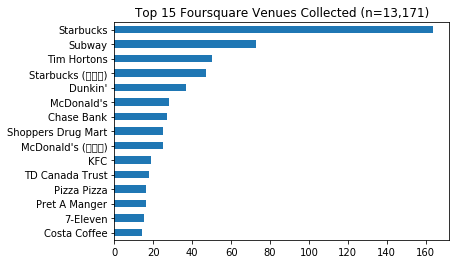

In [17]:
ax = filtered_venues['Venue'].value_counts()[0:15].plot(kind='barh')
ax.invert_yaxis()
plt.title('Top 15 Foursquare Venues Collected (n=13,171)')
plt.show()

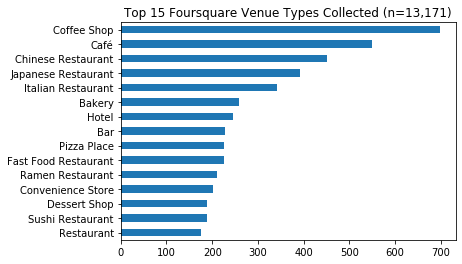

In [18]:
ax = filtered_venues['Venue Category'].value_counts()[0:15].plot(kind='barh')
ax.invert_yaxis()
plt.title('Top 15 Foursquare Venue Types Collected (n=13,171)')
plt.show()

In [19]:
filtered_venues['Category'].value_counts()

Food                     8023
Shop & Service           2543
Nightlife Spot            964
Outdoors & Recreation     610
Travel & Transport        532
Arts & Entertainment      499
Name: Category, dtype: int64

In [20]:
venues_by_neighborhood = filtered_venues.pivot_table(index=['Neighborhood', 'City'], columns='Category', values='Venue', aggfunc='count', fill_value=0)
venues_by_neighborhood

,Category,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport
Neighborhood,City,,,,,,
Aberdeen,Hong Kong,0,14,0,2,2,3
Adelaide,Toronto,1,26,1,2,4,6
Admiralty,Hong Kong,1,26,3,2,6,4
Agincourt,Toronto,0,11,0,0,0,1
Agincourt North,Toronto,0,8,0,0,2,0
...,...,...,...,...,...,...,...
Zhongguancun,Beijing,0,6,0,0,2,1
Zōshigaya,Tokyo,1,10,0,1,3,3
one-north,Singapore,0,24,1,1,1,0


### Convert neighborhood venue type counts to frequencies

In [21]:
neighborhood_venue_frequency = venues_by_neighborhood.div(venues_by_neighborhood.sum(axis=1), axis=0)
neighborhood_venue_frequency

,Category,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport
Neighborhood,City,,,,,,
Aberdeen,Hong Kong,0.000000,0.666667,0.000000,0.095238,0.095238,0.142857
Adelaide,Toronto,0.025000,0.650000,0.025000,0.050000,0.100000,0.150000
Admiralty,Hong Kong,0.023810,0.619048,0.071429,0.047619,0.142857,0.095238
Agincourt,Toronto,0.000000,0.916667,0.000000,0.000000,0.000000,0.083333
Agincourt North,Toronto,0.000000,0.800000,0.000000,0.000000,0.200000,0.000000
...,...,...,...,...,...,...,...
Zhongguancun,Beijing,0.000000,0.666667,0.000000,0.000000,0.222222,0.111111
Zōshigaya,Tokyo,0.055556,0.555556,0.000000,0.055556,0.166667,0.166667
one-north,Singapore,0.000000,0.888889,0.037037,0.037037,0.037037,0.000000


In [22]:
neighborhood_venue_frequency.to_csv('data/world_neighborhood_venues_frequency.csv')